# Connect to google account

In [1]:
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


In [2]:
# 코렙 한글깨짐 방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 데이터 시각화에 사용할 라이브러리
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# 브라우저에서 바로 그려지도록
%matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')

# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (6,454 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123595 files and dire

# Global Variables

In [3]:
import os
import numpy as np
import random
import torch

def reset_seeds(seed=500):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)    # 파이썬 환경변수 시드 고정
  np.random.seed(seed)
  torch.manual_seed(seed) # cpu 연산 무작위 고정
  torch.cuda.manual_seed(seed) # gpu 연산 무작위 고정
  torch.backends.cudnn.deterministic = True  # cuda 라이브러리에서 Deterministic(결정론적)으로 예측하기 (예측에 대한 불확실성 제거 )

In [4]:
import easydict
args = easydict.EasyDict()

# path 정보
args.default_path = '/content/data/MyDrive/AI_study/1. Machine Learning/3. Supervised Learning/original data/'
args.train_csv = args.default_path+'train.csv'
args.test_csv = args.default_path+'test.csv'
args.default_submission_csv = args.default_path+'submission.csv'

args.submission_csv = args.default_path+'result/submission_0828_catboost.csv'
args.save_results = args.default_path+"result/model_results.json"

# 데이터 분석을 위한 변수들
args.random_state = 50 # 위의 셀에서 고정 시킴
args.results = []

# Load Tritanic

- Surived:0=사망, 1=생존
- Pclass: 1=1등석, 2=2등석, 3=3등석
- gender:male=남성, female=여성
- Age: 나이
- SibSp: 타이타닉 호에 동승한 자매/배우자의 수
- Parch: 타이타닉 호에 동승한 부모/자식의 수
- Ticket: 티켓 번호
- Fare: 승객 요금
- Cabin: 방 호수
- Embarked: 탑승지; C=셰르부르, Q=퀴즈타운, S=사우샘프턴

In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
plt.ion()

import warnings
warnings.filterwarnings('ignore')

In [6]:
ori_train = pd.read_csv(args.train_csv)
ori_test = pd.read_csv(args.test_csv)

ori_train.shape, ori_test.shape

((916, 12), (393, 11))

In [7]:
pd.read_csv(args.default_submission_csv).shape

(393, 2)

In [8]:
ori_train.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [9]:
ori_train.head()

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [10]:
ori_train['passengerid'].nunique(), ori_train.shape[0]

(916, 916)

In [11]:
ori_train.drop('passengerid', axis=1, inplace=True)
ori_train.head()

,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [12]:
ori_test.set_index(['passengerid'], inplace=True)
print(f'{ori_test.shape}')
ori_test.head()

(393, 10)


,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
passengerid,,,,,,,,,,
916,3,"McGowan, Miss. Anna ""Annie""",female,15.0,0,0,330923,8.0292,NaN,Q
917,2,"Pinsky, Mrs. (Rosa)",female,32.0,0,0,234604,13.0000,NaN,S
918,3,"McCarthy, Miss. Catherine Katie""""",female,NaN,0,0,383123,7.7500,NaN,Q
919,3,"Franklin, Mr. Charles (Charles Fardon)",male,NaN,0,0,SOTON/O.Q. 3101314,7.2500,NaN,S
920,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,45.0,1,1,36928,164.8667,NaN,S


# train_test_split

In [13]:
new_survived = pd.Categorical(ori_train["survived"])
new_survived = new_survived.rename_categories(["Died","Survived"])

new_survived.describe()

,counts,freqs
categories,,
Died,570,0.622271
Survived,346,0.377729


In [14]:
from sklearn.model_selection import train_test_split

In [15]:
y = ori_train['survived']
X = ori_train.drop(['survived'], axis=1)

In [16]:
reset_seeds()
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, stratify=ori_train['survived'])

X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((641, 10), (275, 10), (641,), (275,))

# Base ModelV0

In [17]:
train = X_tr.copy()
test = X_te.copy()
ori_te = ori_test.copy()

train.shape, test.shape, ori_te.shape

((641, 10), (275, 10), (393, 10))

## Data Preprocessing

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 641 entries, 582 to 286
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    641 non-null    int64  
 1   name      641 non-null    object 
 2   gender    641 non-null    object 
 3   age       520 non-null    float64
 4   sibsp     641 non-null    int64  
 5   parch     641 non-null    int64  
 6   ticket    641 non-null    object 
 7   fare      641 non-null    float64
 8   cabin     153 non-null    object 
 9   embarked  640 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 55.1+ KB


drop columns

In [19]:
print(f'before: {train.shape} / {test.shape}')
drop_cols = ['name', 'ticket', 'cabin']

train.drop(drop_cols, axis=1, inplace=True) # 모델이 학습하는데 사용하는 데이터
test.drop(drop_cols, axis=1, inplace=True) # 모델의 학습을 평가(잘했는지?? 못했는지??)하기 위한 데이터
ori_te.drop(drop_cols, axis=1, inplace=True) # 학습이 잘된 모델을 이용해서 내가 알고 싶은(ori_te) 데이터를 예측하게 하는 것

print(f'after: {train.shape} / {test.shape}')
train.info()

before: (641, 10) / (275, 10)
after: (641, 7) / (275, 7)
<class 'pandas.core.frame.DataFrame'>
Index: 641 entries, 582 to 286
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    641 non-null    int64  
 1   gender    641 non-null    object 
 2   age       520 non-null    float64
 3   sibsp     641 non-null    int64  
 4   parch     641 non-null    int64  
 5   fare      641 non-null    float64
 6   embarked  640 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 40.1+ KB


missing value

In [20]:
train.isnull().sum()

,0
pclass,0
gender,0
age,121
sibsp,0
parch,0
fare,0
embarked,1


In [21]:
test.isnull().sum()

,0
pclass,0
gender,0
age,59
sibsp,0
parch,0
fare,0
embarked,0


In [22]:
ori_te.isnull().sum()

,0
pclass,0
gender,0
age,83
sibsp,0
parch,0
fare,1
embarked,1


In [23]:
age_median = train['age'].median()
fare_median = train['fare'].median()
embarked_mode = train['embarked'].mode().values[0]

age_median, fare_median, embarked_mode

(27.0, 14.5, 'S')

In [24]:
train['age'].fillna(age_median, inplace=True)
test['age'].fillna(age_median, inplace=True)
ori_te['age'].fillna(age_median, inplace=True)

train['fare'].fillna(fare_median, inplace=True)
test['fare'].fillna(fare_median, inplace=True)
ori_te['fare'].fillna(fare_median, inplace=True)

train['embarked'].fillna(embarked_mode, inplace=True)
test['embarked'].fillna(embarked_mode, inplace=True)
ori_te['embarked'].fillna(embarked_mode, inplace=True)

train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

data encoding

In [25]:
from sklearn.preprocessing import OneHotEncoder

In [26]:
train.columns

Index(['pclass', 'gender', 'age', 'sibsp', 'parch', 'fare', 'embarked'], dtype='object')

In [27]:
enc_cols = ['gender', 'embarked']
normal_cols = list(set(train.columns) - set(enc_cols))
normal_cols

['parch', 'pclass', 'age', 'sibsp', 'fare']

In [28]:
print(f'before: {train.shape} / {test.shape}')

enc = OneHotEncoder()
# train
tmp_tr = pd.DataFrame(
    enc.fit_transform(train[enc_cols]).toarray(),
    columns = enc.get_feature_names_out()
)
enc_tr = pd.concat(
    [train[normal_cols].reset_index(drop=True), tmp_tr.reset_index(drop=True)]
    , axis=1
)
# test
tmp_te = pd.DataFrame(
    enc.transform(test[enc_cols]).toarray(),
    columns = enc.get_feature_names_out()
)
enc_te = pd.concat(
    [test[normal_cols].reset_index(drop=True), tmp_te.reset_index(drop=True)]
    , axis=1
)
# ori_test
tmp_te = pd.DataFrame(
    enc.transform(ori_te[enc_cols]).toarray(),
    columns = enc.get_feature_names_out()
)
enc_ori_te = pd.concat(
    [ori_te[normal_cols].reset_index(drop=True), tmp_te.reset_index(drop=True)]
    , axis=1
)

print(f'after: {enc_tr.shape} / {enc_te.shape}')
enc_tr.head()

before: (641, 7) / (275, 7)
after: (641, 10) / (275, 10)


,parch,pclass,age,sibsp,fare,gender_female,gender_male,embarked_C,embarked_Q,embarked_S
0,0,3,32.0,0,7.9250,0.0,1.0,0.0,0.0,1.0
1,0,2,21.0,0,11.5000,0.0,1.0,0.0,0.0,1.0
2,0,3,27.0,0,7.7750,0.0,1.0,0.0,0.0,1.0
3,0,3,19.0,0,7.8958,0.0,1.0,0.0,0.0,1.0
4,0,3,74.0,0,7.7750,0.0,1.0,0.0,0.0,1.0


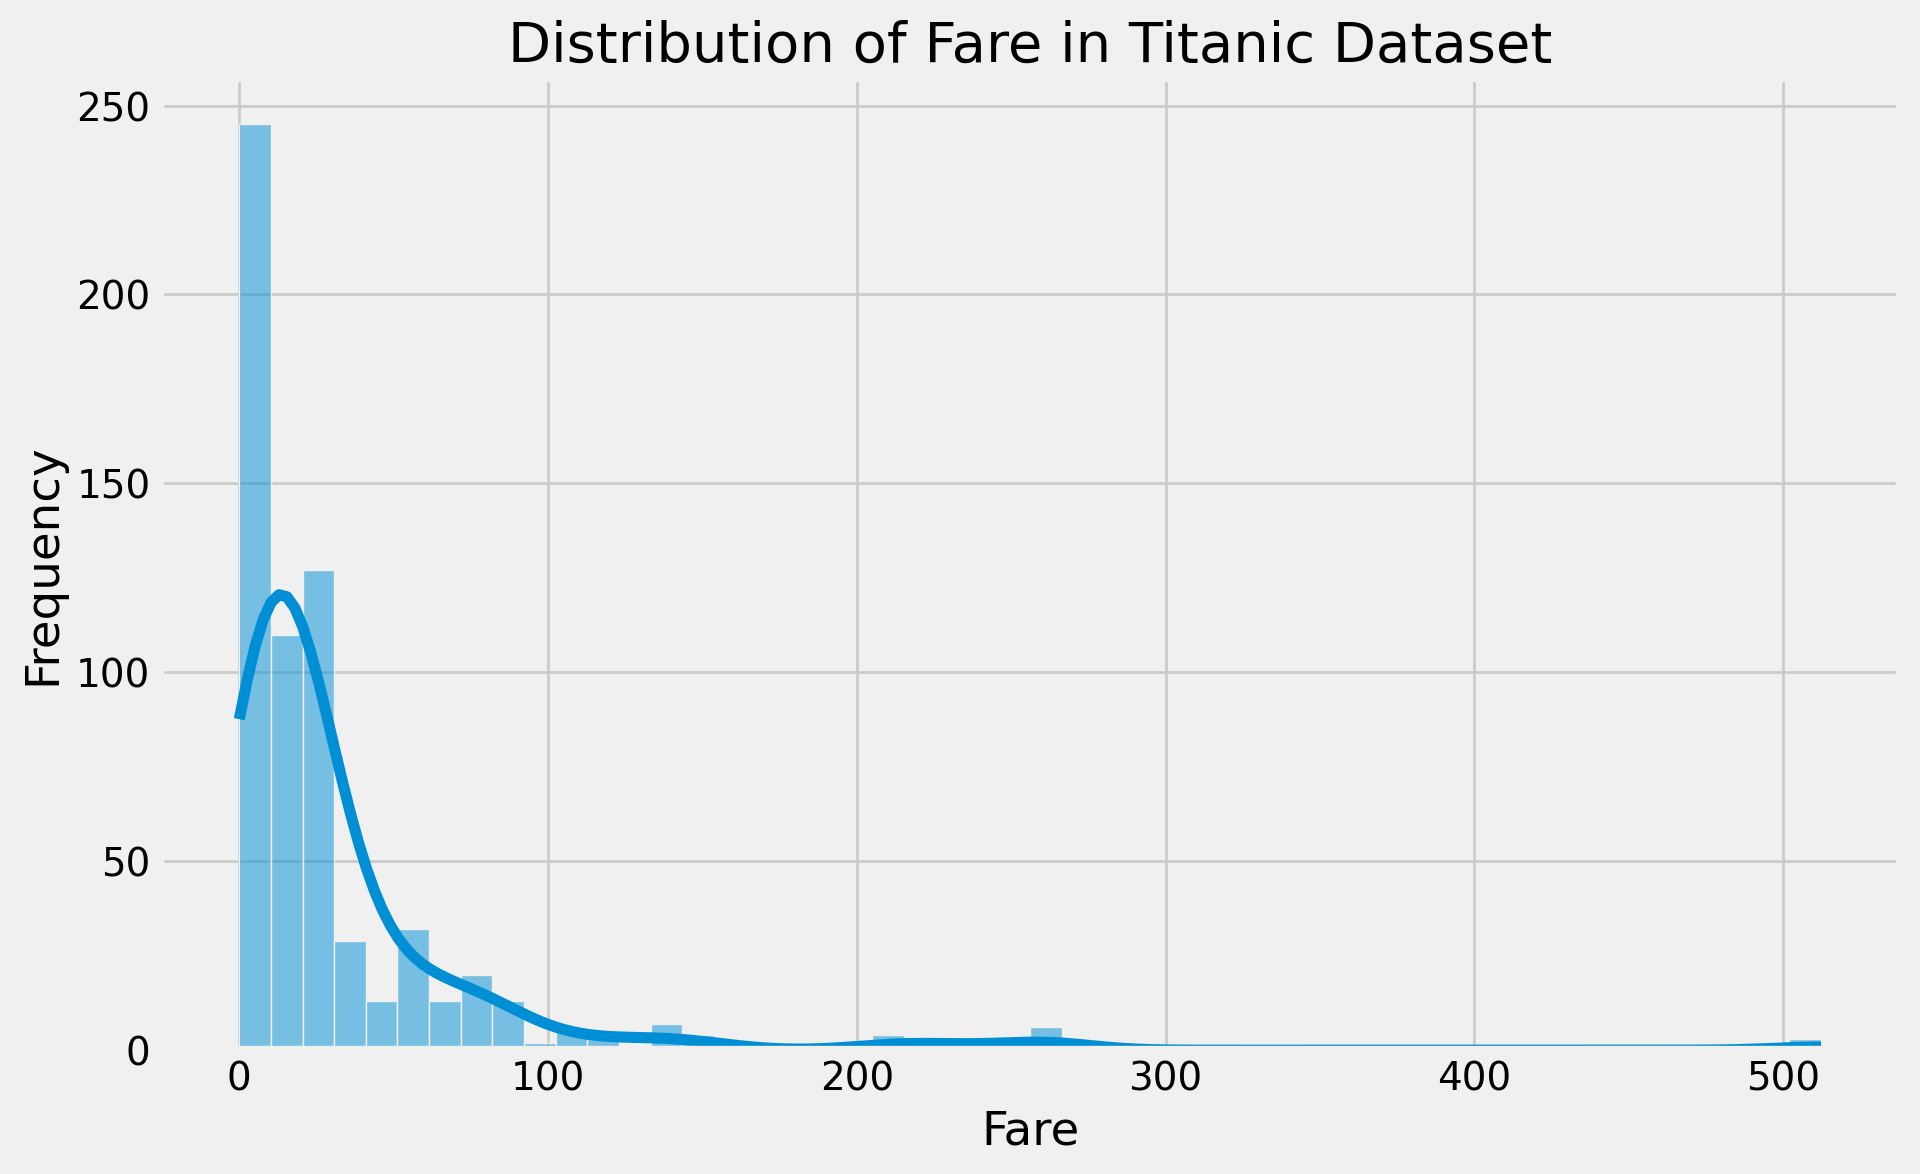

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Fare 컬럼의 분포를 시각화
plt.figure(figsize=(10, 6))
sns.histplot(enc_tr['fare'], bins=50, kde=True)
plt.title('Distribution of Fare in Titanic Dataset')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.show()


## Training

In [30]:
enc_tr.isnull().sum().sum(), enc_te.isnull().sum().sum(), enc_ori_te.isnull().sum().sum()

(0, 0, 0)

In [31]:
enc_tr.shape, enc_te.shape, enc_ori_te.shape

((641, 10), (275, 10), (393, 10))

In [32]:
from sklearn.ensemble import VotingClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [33]:
SEED = args.random_state
estimators = [
    ( "mlp" , MLPClassifier(max_iter=1000,random_state=SEED) ),
    ( "lr" , LogisticRegression(random_state=SEED) ),
    ( "rf" , RandomForestClassifier(random_state=SEED) )
]
hp = {
    "estimators" : estimators,
    "voting" : "soft"
}
# from sklearn.model_selection import cross_val_predict # 교차검증
modelV0 = VotingClassifier(**hp).fit(X_tr, y_tr)
# y_tr = cross_val_predict(modelV0, X_tr, y_tr, cv=5)
print(f'{X_tr.shape} / {y_tr.shape}')
# modelV0.fit(X_tr, y_tr)

ValueError: could not convert string to float: 'Jussila, Mr. Eiriik'

## Evaluation

In [ ]:
score_tr = modelV0.score(enc_tr, y_tr)
score_te = modelV0.score(enc_te, y_te)

score_tr, score_te

In [ ]:
from sklearn.metrics import roc_curve, auc

y_pred = modelV0.predict_proba(enc_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te,y_pred)
print(y_pred.shape)
auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

In [ ]:
ori_te_pred = modelV0.predict_proba(enc_ori_te)[:,1]
ori_te_pred.shape

In [ ]:
modelV0.feature_importances_

In [ ]:
df_feature_importances = pd.DataFrame(modelV0.feature_importances_, enc_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances

In [ ]:
args.results.append(
    {
        'model': 'modelV4',
        'score_tr': score_tr,
        'score_te': score_te,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': '0217'
    }
)

args.results

# Submission

In [ ]:
df_results = pd.DataFrame(args.results).sort_values(by=['auc_te'], ascending=False)
df_results

In [ ]:
submission = pd.read_csv(args.default_submission_csv)
submission.head()

In [ ]:
submission['survived'] = df_results.loc[0, ['ori_te_pred']].values[0]

print(f'{submission.isnull().sum().sum()}')
submission.head(10)

In [ ]:
submission.to_csv(args.submission_csv, header=True, index=False)

# Save Results

In [ ]:
args.save_results

In [ ]:
df_results.columns

In [ ]:
df_results.drop(['ori_te_pred'], axis=1, inplace=True)

In [ ]:
df_results.to_json(args.save_results, orient="records")

In [ ]:
# 어떤 모델이 일을 잘했는지 확인 가능
df_results.head()

In [ ]:
import json

load_results = None
with open(args.save_results, 'r') as file:
    load_results = json.load(file)

load_results

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 예시 데이터 (실제 데이터로 교체하세요)
actual = y_te
predict = y_pred  # 예측값

# 임계값 설정
threshold = 0.5
predict_binary = (predict >= threshold).astype(int)

# Confusion Matrix 계산
cm = confusion_matrix(actual, predict_binary, normalize="true")

# Confusion Matrix 출력
print("Confusion Matrix:")
print(cm)

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()
